In [14]:
from fit_completeness_to_catalog import *
import os
name = "sullivan"
cut_to_Ms = True
nwalkers = 24
ndim = 8
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Selected 907 stars


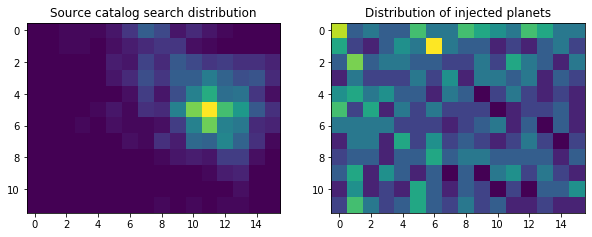

Injected 575 transiting planets


In [15]:
catalog, num_stars = get_catalog_and_numstars(name, cut_to_Ms)
num_stars = 10000
if os.path.isfile('synth{}.h5'.format(str(num_stars))):
    synth = pd.read_hdf('synth{}.h5'.format(str(num_stars)))
else:
    print("Making synth solar systems")
    synth = make_synth_solar_systems(num_stars=num_stars)
    synth.to_hdf('synth{}.h5'.format(str(num_stars)), key='synth')
synth = synth[synth.transit_bool]
hist_synth, hist_catalog = make_hists(synth, catalog)
print("Injected {} transiting planets".format(int(np.sum(hist_synth))))

In [16]:
ll, p0 = make_mcmc_setup(hist_synth, hist_catalog, nwalkers)
sampler = emcee.EnsembleSampler(nwalkers, ndim, ll)
_ = sampler.run_mcmc(p0, 10000, progress="notebook")
sampler.reset()
pos, _, _ = sampler.run_mcmc(p0, 50000, store=True, progress="notebook")

Found least-squares solution: [-1.72160683e-01 -1.88176285e-02 -4.25987520e-04 -4.97820708e-02
  3.61702286e-01  9.47037963e-02  1.60079795e+00 -3.60754374e-01]
Set initial condition


/Users/adityasengupta/projects/pals/tesscomp-prototyping/fit_completeness_to_catalog.py:121: RuntimeWarning: invalid value encountered in log
  ll_mat = D * np.log(mu) - mu - log_fact_D


In [17]:
i = 0
while True:
    try:
        print(sampler.get_autocorr_time())
        break
    except BaseException:
        sampler.run_mcmc(np.median(sampler.chain[:,-1000:,:], axis=1), 1000, store=True)
        print(i)
        i += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
[1751.91924311 1078.48833088  935.8309957   981.32452582 1719.18592368
 1134.61055191  947.55502225 1104.1499954 ]


In [18]:
sampler.get_autocorr_time()

array([1751.91924311, 1078.48833088,  935.8309957 ,  981.32452582,
       1719.18592368, 1134.61055191,  947.55502225, 1104.1499954 ])

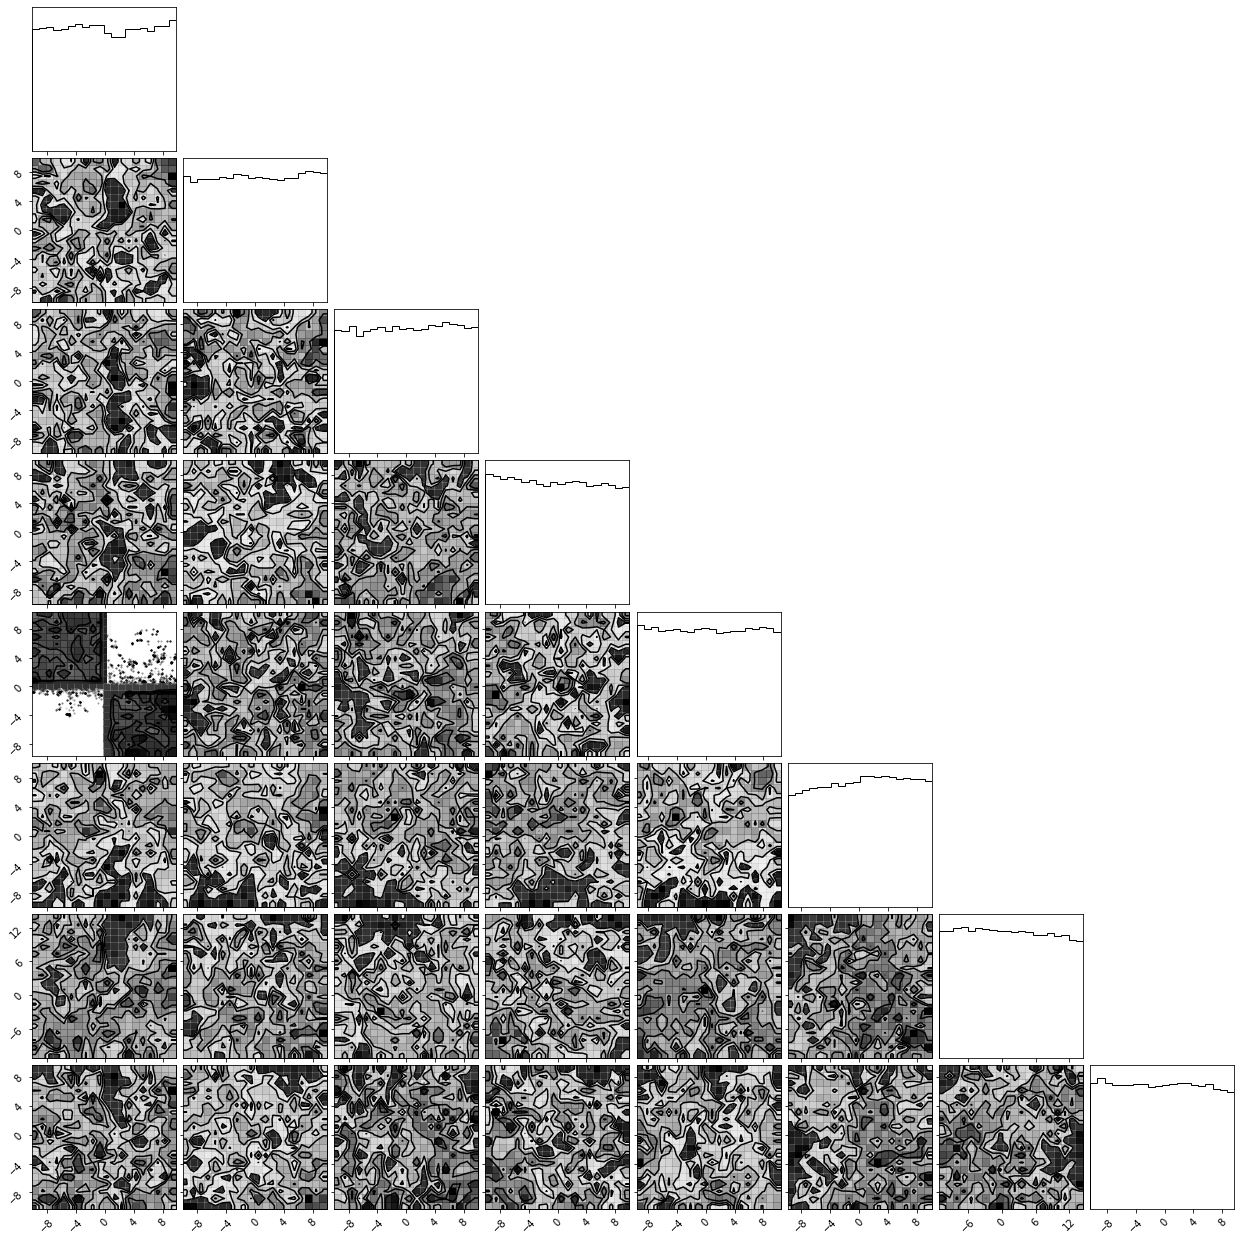

In [19]:
_ = corner.corner(sampler.flatchain) # check autocorrelation times

In [20]:
from IPython.display import display, Math
labels = ['p0', 'p1', 'p2', 'p3', 'r0', 'r1', 'r2', 'r3']

best_params = np.empty(ndim,)
for i in range(ndim):
    mcmc = np.percentile(sampler.get_chain(discard=100, thin=15, flat=True)[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    best_params[i] = mcmc[1]
    display(Math(txt))
# cut off days at 27, or at 90th percentile for TOIs

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [21]:
comp_p = comp_poly(bins_p, *best_params[:4])
comp_r = comp_poly(bins_r, *best_params[4:])
comp_p -= np.min(comp_p)
comp_p /= np.max(comp_p)
comp_r -= np.min(comp_r)
comp_r /= np.max(comp_r)

In [22]:
comp_p

array([1.        , 0.99999307, 0.99998104, 0.9999593 , 0.99991709,
       0.99982511, 0.99958962, 0.99887084, 0.99632855, 0.98639554,
       0.94523375, 0.76894814, 0.        ])

In [23]:
comp_r

array([0.        , 0.00272321, 0.00617862, 0.01061807, 0.01639441,
       0.02400541, 0.03415744, 0.04785822, 0.06655196, 0.09231673,
       0.12815307, 0.17840649, 0.2493867 , 0.35027611, 0.49446356,
       0.70150407, 1.        ])

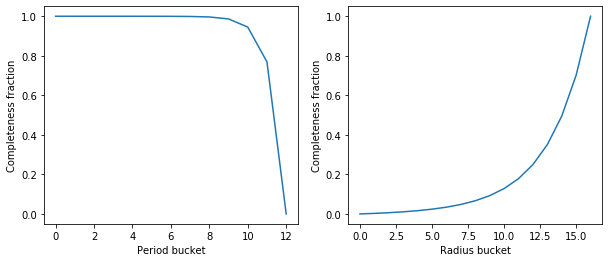

In [24]:
plot_marginalized_comps(comp_p, comp_r)

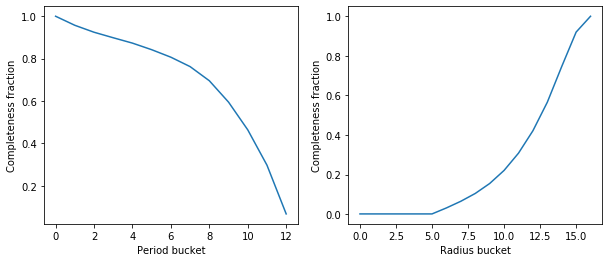

In [25]:
comp04m = np.load('ballard_data/Completeness_0.4Msun.npy')
num_iters = 100
rcomp_marginalized = np.mean(comp04m[-1].dot(np.random.uniform(size=(13,num_iters))), axis=1)
rcomp_marginalized /= rcomp_marginalized[-1]
pcomp_marginalized = np.mean(comp04m[-1].T.dot(np.random.uniform(size=(17,num_iters))), axis=1)
pcomp_marginalized /= pcomp_marginalized[0]
plot_marginalized_comps(pcomp_marginalized, rcomp_marginalized)

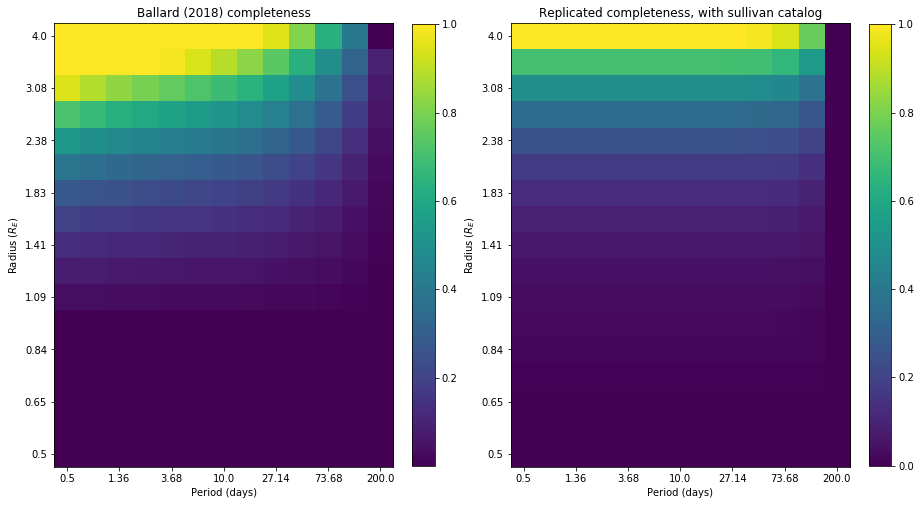

In [26]:
repcomp = np.outer(comp_p, comp_r).T
plot_overall_comps(repcomp, name)